In [13]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')

    if type(rxns) != list:
        rxns = [rxns]

    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log10(k))

    if labels:
        plt.legend(labels)
    plt.show()


## Load Database

In [3]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'primaryNS',
    'NitrogenCurran',
    'NOx2018',
    'FFCM1(-)',
    'SulfurLibrary',
    'SulfurGlarborgH2S',
    'SABIC_aromatics',
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
    kinetics_families = 'all',
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False, # Don't bother loading the depository information, as we don't use it
)

In [15]:
# Load the model

# Must use annotated chemkin file
chemkin_file = 'RMG-MAX1/chem_annotated.inp'
dict_file = 'RMG-MAX1/species_dictionary.txt'

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_file, dict_file)


# Rebuild tree to get training reactions in each node

In [5]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
# for family_name in database.kinetics.families.keys():
for family_name in ['Disproportionation']:
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)


In [7]:
# Want to see if I can reproduce a node's rule using a recently regenerated Disproportionation Tree

nodes = list(database.kinetics.families['Disproportionation'].rules.entries)

node = nodes[0]
node = 'Root_Ext-1R!H-R_4R->O'

rxns = auto_gen_families['Disproportionation_rxn_map'][node]


recipe = database.kinetics.families['Disproportionation'].forward_recipe
kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)

In [8]:
kin

ArrheniusBM(A=(6.66628e+17,'m^3/(mol*s)'), n=-3.63731, w0=(563000,'J/mol'), E0=(85735.5,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 12 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")

In [9]:
database.kinetics.families['Disproportionation'].rules.entries[node][0].data

ArrheniusBM(A=(6.66628e+17,'m^3/(mol*s)'), n=-3.63731, w0=(563000,'J/mol'), E0=(85735.5,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), uncertainty=RateUncertainty(mu=0.20739942627141006, var=2.6655742044913753, Tref=1000.0, N=12, data_mean=0.0, correlation='Root_Ext-1R!H-R_4R->O',), comment="""BM rule fitted to 12 training reactions at node Root_Ext-1R!H-R_4R->O
    Total Standard Deviation in ln(k): 3.7941521125402273""")

In [ ]:
recipe = database.kinetics.families['Disproportionation'].forward_recipe
rxns = auto_gen_families['Disproportionation_rxn_map'][node]
rxns = np.array(rxns)

label = node
Tref = 1000.0
data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

n = len(rxns)

dlnks = np.array([
    np.log(
        rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
        .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
        .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
    ) for i, rxn in enumerate(rxns)
])


varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
# weighted average calculations
ws = 1.0 / varis
V1 = ws.sum()
V2 = (ws ** 2).sum()
mu = np.dot(ws, dlnks) / V1
s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)


print(kin_uncertainty)

In [ ]:
kin_uncertainty.get_expected_log_uncertainty()

In [ ]:
kin_uncertainty.get_expected_log_uncertainty() / .398

In [27]:
source[1][1]

{'template': '',
 'degeneracy': 2.0,
 'exact': False,
 'rules': '',
 'training': '',
 'node': 'Root_Ext-1R!H-R_4R->O'}

# Plot Kinetics of a node

Node: Root_Ext-1R!H-R_4R->O
62.1324 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
56.6932 kJ/mol		0
25.104 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
Reactions Estimated with node: 0


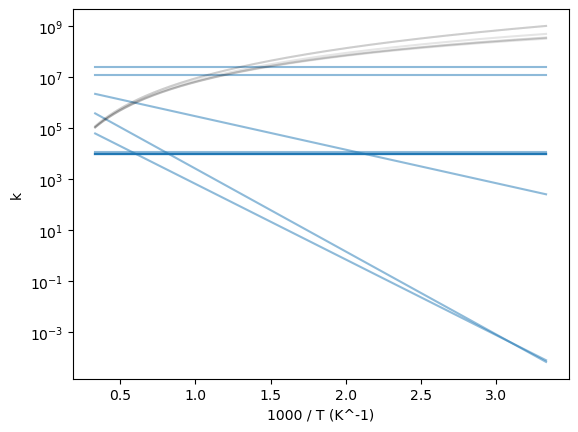

In [35]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# node = list(auto_gen_families[f'{family}_rxn_map'].keys())[44]
node = 'Root_Ext-1R!H-R_4R->O'

# # Find nodes that matter
# for a in range(len(list(auto_gen_families[f'{family}_rxn_map'].keys()))):
#     node = list(auto_gen_families[f'{family}_rxn_map'].keys())[a]
#     reaction_indices = []
#     for z in range(len(reaction_list)):
#         if not hasattr(reaction_list[z], 'family') or reaction_list[z].family != family:
#             continue
#         source = database.kinetics.families[family].extract_source_from_comments(reaction_list[z])
#         if source[0]:
#             continue  # exact match
#         if source[1][1]['node'] == node:
#             reaction_indices.append(z)
#     if len(reaction_indices) > 0:
#         print(a, len(reaction_indices))



print(f'Node: {node}')
plt.xlabel('1000 / T (K^-1)')
plt.ylabel('k')


T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=z, color=colors[0], alpha=0.5)
    print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}')
    
    
# Also plot the average of the kinetics? Except that isn't even relevant to the BM tree?
# It's an approximation. Good enough for just looking at the trees

# Maybe I plot the reactions that are estimated using that node...
reaction_indices = []
for z in range(len(reaction_list)):
    if not hasattr(reaction_list[z], 'family') or reaction_list[z].family != family:
        continue
    source = database.kinetics.families[family].extract_source_from_comments(reaction_list[z])
    if source[0]:
        continue  # exact match
    if source[1][1]['node'] == node:
        # plot this reaction
        rxn = reaction_list[z]
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
            k[j] = rxn.get_rate_coefficient(T[j])
        plt.plot(1000.0 / T, k, label=z, color='black', alpha=0.1)
                
#                 break
#                 print(z)
print(f'Reactions Estimated with node: {len(reaction_indices)}')            
    
plt.yscale('log')

# plt.legend()
plt.show()





In [38]:
# Try getting a different fit:

node = 'Root_Ext-1R!H-R_4R->O'
rxns = auto_gen_families['Disproportionation_rxn_map'][node]


[print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}') for rxn in rxns] 

recipe = database.kinetics.families['Disproportionation'].forward_recipe
kin = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions)


62.1324 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
56.6932 kJ/mol		0
25.104 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0
0 kJ/mol		0


In [39]:
kin

ArrheniusBM(A=(6.66628e+17,'m^3/(mol*s)'), n=-3.63731, w0=(563000,'J/mol'), E0=(85735.5,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 12 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")

In [40]:
kin2 = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns, recipe=recipe.actions, b0=0.0)

In [41]:
kin2

ArrheniusBM(A=(6.66628e+17,'m^3/(mol*s)'), n=-3.63731, w0=(563000,'J/mol'), E0=(85735.5,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 12 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")

In [ ]:
# plot the leave one out version

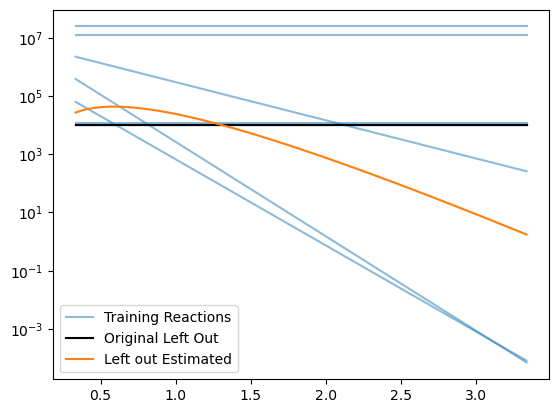

In [61]:
# Given a node, I want to plot all the kinetics, the average kinetics, and the std_dev
family = 'Disproportionation'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
node = 'Root_Ext-1R!H-R_4R->O'

left_out_index = 11

Tref = 1000.0
T = np.linspace(300, 3000, 1001)
for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
    rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
    k = np.zeros(len(T))
    for j in range(0, len(T)):
        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
        k[j] = rxn.get_rate_coefficient(T[j])
    if z == left_out_index:
        plt.plot(1000.0 / T, k, color='black', label='Original Left Out')
    elif z == (left_out_index + 1) % len(auto_gen_families[f'{family}_rxn_map'][node]):
        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
    else:
        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
#     print(f'{rxn.kinetics.Ea}\t\t{rxn.kinetics.n}')
     
plt.yscale('log')


# Estimate the kinetics leaving out that reaction
rxns = np.array(rxns)
recipe = database.kinetics.families['Disproportionation'].forward_recipe
left_out_kin_BM = rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {left_out_index})], recipe=recipe.actions)

left_out_kin = left_out_kin_BM.to_arrhenius(rxns[left_out_index].get_enthalpy_of_reaction(Tref))

k = np.zeros(len(T))
for j in range(0, len(T)):
    k[j] = left_out_kin.get_rate_coefficient(T[j])
plt.plot(1000.0 / T, k, label='Left out Estimated', color=colors[1])

plt.legend()
plt.show()

In [48]:
left_out_kin.to_arrhenius()

ArrheniusBM(A=(3.93449e+18,'m^3/(mol*s)'), n=-3.89708, w0=(563000,'J/mol'), E0=(84001,'J/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), comment="""Fitted to 11 reactions at temperatures: [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]""")

In [ ]:
rxn.get_enthalpy_of_reaction(Tref)